https://nbviewer.jupyter.org/github/zerebom/Sandbox/blob/master/pytorch_book/2_objectdetection/2-8_SSD_inference.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.utils.data as data
#import VOC_SSD
import VOC_SSDv2
from itertools import product as product
%matplotlib inline


In [2]:
!ls -lh v3_voc/weights

total 264M
-rw-rw-r-- 1 redne redne 93M May 30 20:42 ssd300_10.pth
-rw-rw-r-- 1 redne redne 93M May 31 00:08 ssd300_2.pth
-rw-rw-r-- 1 redne redne 79M Mar 13  2017 vgg16_reducedfc.pth


In [3]:


voc_classes =  ['fork', 'spoon', 'knife', 'coffeeCup', 'clearCup']

# get device ( cpu / gpu ) to be used
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(f'device : {device}')

# SSD300の設定
ssd_cfg = {
    'num_classes': 6,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = VOC_SSDv2.SSD(phase="inference", cfg=ssd_cfg).to("cuda")
#net = VOC_SSD.SSD(phase="inference", cfg=ssd_cfg) #.to("cuda")
#net = SSD(phase="inference", cfg=ssd_cfg)
#net = SSD(Bottleneck, [2,2,2,2], phase="inference", cfg=ssd_cfg).to("cuda")


#net = SSDv2.SSD(phase="inference", cfg=ssd_cfg)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("using:", device)

# SSDの学習済みの重みを設定
net_weights = torch.load('./v3_voc/weights/ssd300_2.pth', map_location=device)

#net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('loaded the trained weights')



#net = net.to(device)
net = net.cuda()
net.eval()


device : cuda
loaded the trained weights


SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [5]:
from torch.autograd import Variable
input=Variable(torch.randn(1, 6, 200, 3))
output=net(input)

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 6, 200, 3] to have 3 channels, but got 6 channels instead

In [260]:
import VOCdataset

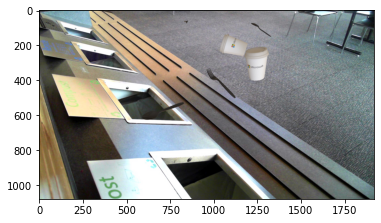

In [261]:
# 1. 画像読み込み
#image_file_path = "./data/cowboy-757575_640.jpg"
image_file_path = "/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得
img.shape

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

from efficientdet.utils.ssd_model import DataTransform
transform = DataTransform(input_size, color_mean)
#transform = VOCdataset.VOC_DataTransform(input_size, color_mean)

#https://github.com/abeja-inc/platform-template-object-detection/blob/a41bc5842f73faa40fe9b2ff798eafeb795de123/predict.py
# the dataset's mean rgb values,
#transform = DataTransform(
#    input_size=Parameters.IMG_SIZE,
#    color_mean=Parameters.MEANS)

In [262]:
phase = "val"
img_transformed, boxes, labels = transform(img, phase, "", "")
img_transformed = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

In [263]:
import torch.autograd as autograd

In [264]:
x = autograd.Variable(img_transformed.unsqueeze(0), requires_grad=True).cuda()

In [245]:
test = torch.tensor(x, requires_grad=False, device='cuda').type(torch.FloatTensor).cuda()

/home/redne/anaconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [248]:
detections = net(test).max(-1)[1].view(1, 1).item()

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [266]:
# 1. 画像読み込み
#image_file_path = "./data/cowboy-757575_640.jpg"
image_file_path = "/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得
img.shape

(1080, 1920, 3)

In [268]:
# pick one image from the test set
#img, _ = dataset_test[0]
# put the model in evaluation mode
net.eval()
with torch.no_grad():
    prediction = net(Variable(img_transformed.unsqueeze(0),requires_grad=False).to(device))

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [253]:
sample = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
sample

AttributeError: 'numpy.ndarray' object has no attribute 'mul'

In [235]:
net.__dict__['detect'].__dict__

{'softmax': Softmax(dim=-1),
 'conf_thresh': 0.01,
 'top_k': 200,
 'nms_thresh': 0.45}

In [254]:
phase = "val"
img_transformed, boxes, labels = transform(img, phase, "", "")
#img_transformed = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)
img_transformed = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)
#x = Variable(img.unsqueeze(0))

In [223]:
x = Variable(img_transformed.unsqueeze(0))

In [225]:
x.size()

torch.Size([1, 3, 300, 300])

In [199]:
img_transformed.size()

torch.Size([3, 300, 300])

In [201]:
x = x.cuda()

In [203]:
y = net(x)

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [166]:
img_transformed.unsqueeze(0).size()

torch.Size([1, 3, 300, 300])

In [161]:
img_transformed = img_transformed[:-1,:,:]

In [167]:
img_transformed.size()

torch.Size([3, 300, 300])

In [182]:
import torchvision

color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

class v3_ConvertFromInts(object):
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32), boxes, labels

class v3_SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), boxes, labels


class v3_Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image, boxes, labels
    
    
v3_transform = torchvision.transforms.Compose([
    #v3_ConvertFromInts(),
    v3_Resize(input_size),
    v3_SubtractMeans(color_mean)
    ])

In [183]:
from PIL import Image

In [184]:
image = Image.open("/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg")
image = v3_transform(image)

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [168]:
net(Variable(img_transformed.unsqueeze(0),requires_grad=False))

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [148]:
%matplotlib inline
def imshow(img):
    #img = img*0.5 + 0.5     # unnormalize
	#npimg = img.numpy()
    img_transformed = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)
    plt.imshow(img_transformed)

In [125]:
with torch.no_grad():
    x = list(t.to(device) for t in torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1))

In [130]:
x[0]

tensor([[-66.3900, -64.9000, -61.0000,  ..., -74.9500, -87.8300, -83.6700],
        [-64.5300, -59.9100, -59.5000,  ..., -28.8000, -75.3800, -87.5000],
        [-62.4500, -57.1500, -49.5000,  ..., -47.7500, -84.3000, -94.5000],
        ...,
        [ 51.4500,  57.0000,  59.5000,  ..., -32.2500, -33.1500, -39.0500],
        [ 50.9000,  56.6100,  54.0000,  ..., -41.2000, -36.4800, -44.2000],
        [ 45.3000,  48.5700,  53.8000,  ..., -43.5000, -33.7000, -43.1800]],
       device='cuda:0')

In [108]:
img_transformed = img_transformed.unsqueeze(0).cuda()

In [114]:
with torch.no_grad():
    detection = net(Variable(img_transformed, requires_grad=True))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 300, 300] instead

In [94]:
from VOC_SSD_EVAL import SSDPredictShow

# ファイルパス
image_file_path = "/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net, device=device)
ssd.show(image_file_path, data_confidence_level=0.6)

cuda
torch.Size([3, 300, 300])


RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [ ]:
y = net(xx)

In [58]:
from torch.autograd import Variable
xx = Variable(img_transformed.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [59]:
x = Variable(img_transformed.unsqueeze(0))

In [60]:
x

tensor([[[[-66.3900, -64.9000, -61.0000,  ..., -74.9500, -87.8300, -83.6700],
          [-64.5300, -59.9100, -59.5000,  ..., -28.8000, -75.3800, -87.5000],
          [-62.4500, -57.1500, -49.5000,  ..., -47.7500, -84.3000, -94.5000],
          ...,
          [ 51.4500,  57.0000,  59.5000,  ..., -32.2500, -33.1500, -39.0500],
          [ 50.9000,  56.6100,  54.0000,  ..., -41.2000, -36.4800, -44.2000],
          [ 45.3000,  48.5700,  53.8000,  ..., -43.5000, -33.7000, -43.1800]],

         [[-55.0000, -50.3000, -50.2500,  ..., -70.7000, -79.4700, -82.7900],
          [-56.2300, -50.8900, -51.6000,  ...,  -6.1000, -66.1100, -79.8600],
          [-52.4500, -48.1000, -40.2500,  ..., -13.2500, -68.3500, -80.2500],
          ...,
          [ 74.4500,  84.0000,  93.2500,  ...,   2.0000, -13.2500,  -6.6000],
          [ 76.9700,  83.8100,  87.5500,  ...,  -1.3500, -10.9000,  -8.2000],
          [ 78.1000,  80.5700,  86.9500,  ...,  -8.2000, -12.2700,  -6.1800]],

         [[-35.1900, -32.1000,

In [61]:
detections = net(x)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # アノテーションはないので、""にする
img_transformed = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)
# img = img_transformed[:, :, (2, 1, 0)].permute(2, 0, 1)

# 5. SSDで予測
net.eval()  # ネットワークを推論モードへ
x = Variable(img_transformed.unsqueeze(0))
#x = img_transformed.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

In [58]:
img, _boxes, _labels = transform(img, "val", "", "")
img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

In [59]:
from torch.autograd import Variable

x = Variable(img.unsqueeze(0))

In [61]:
res = net(x)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [27]:
from efficientdet.utils.ssd_model import DataTransform
import glob
# 画像に対する予測
from efficientdet.utils.ssd_predict_show import SSDPredictShow

cuda:0
./v3_voc/sample/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg


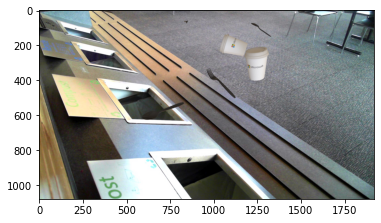

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [28]:
#https://nbviewer.jupyter.org/github/kentaroy47/SSD.objectdetection.pytorch/blob/master/inference.ipynb
# 1. 画像読み込み
#image_file_path = "../../VOCdevkit/VOC2007/JPEGImages/009961.jpg"
image_file_path = "./v3_voc/sample/*.jpg"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ssd = SSDPredictShow(eval_categories=voc_classes, net=net, device=device)
inf = []
for imp in glob.glob(image_file_path):
    print(imp)
    img = cv2.imread(imp)  # [高さ][幅][色BGR]
    height, width, channels = img.shape  # 画像のサイズを取得

    # 2. 元画像の表示
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    # 3. 前処理クラスの作成
    color_mean = (104, 117, 123)  # (BGR)の色の平均値
    input_size = 300  # 画像のinputサイズを300×300にする
    transform = DataTransform(input_size, color_mean)

    # 4. 前処理
    phase = "val"
    img_transformed, boxes, labels = transform(
        img, phase, "", "")  # アノテーションはないので、""にする
    img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

    # 5. SSDで予測
    net.eval()  # ネットワークを推論モードへ
    x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
    
    import time
    tick = time.time()
    x=x.to(device)
    with torch.no_grad():
        detections = net(x)
        toch = time.time()
    print("time for inference:", toch-tick)
    inf.append(toch-tick)
    print(detections.shape)
    #print(detections)

    # output : torch.Size([batch_num, 21, 200, 5])
    #  =（batch_num、クラス、confのtop200、規格化されたBBoxの情報）
    #   規格化されたBBoxの情報（確信度、xmin, ymin, xmax, ymax）
    
    ssd.show(imp, data_confidence_level=0.5)

print("average inference time:", np.mean(inf))

In [2]:

def group_annotation_by_class(dataset):
    true_case_stat = {}
    all_gt_boxes = {}
    all_difficult_cases = {}
    for i in range(len(dataset)):
        image_id, annotation = dataset.get_annotation(i)
        gt_boxes, classes, is_difficult = annotation
        gt_boxes = torch.from_numpy(gt_boxes)
        for i, difficult in enumerate(is_difficult):
            class_index = int(classes[i])
            gt_box = gt_boxes[i]
            if not difficult:
                true_case_stat[class_index] = true_case_stat.get(class_index, 0) + 1

            if class_index not in all_gt_boxes:
                all_gt_boxes[class_index] = {}
            if image_id not in all_gt_boxes[class_index]:
                all_gt_boxes[class_index][image_id] = []
            all_gt_boxes[class_index][image_id].append(gt_box)
            if class_index not in all_difficult_cases:
                all_difficult_cases[class_index]={}
            if image_id not in all_difficult_cases[class_index]:
                all_difficult_cases[class_index][image_id] = []
            all_difficult_cases[class_index][image_id].append(difficult)

    for class_index in all_gt_boxes:
        for image_id in all_gt_boxes[class_index]:
            all_gt_boxes[class_index][image_id] = torch.stack(all_gt_boxes[class_index][image_id])
    for class_index in all_difficult_cases:
        for image_id in all_difficult_cases[class_index]:
            all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])
    return true_case_stat, all_gt_boxes, all_difficult_cases


def compute_average_precision_per_class(num_true_cases, gt_boxes, difficult_cases,
                                        prediction_file, iou_threshold, use_2007_metric):
    with open(prediction_file) as f:
        image_ids = []
        boxes = []
        scores = []
        for line in f:
            t = line.rstrip().split(" ")
            image_ids.append(t[0])
            scores.append(float(t[1]))
            box = torch.tensor([float(v) for v in t[2:]]).unsqueeze(0)
            box -= 1.0  # convert to python format where indexes start from 0
            boxes.append(box)
        scores = np.array(scores)
        sorted_indexes = np.argsort(-scores)
        boxes = [boxes[i] for i in sorted_indexes]
        image_ids = [image_ids[i] for i in sorted_indexes]
        true_positive = np.zeros(len(image_ids))
        false_positive = np.zeros(len(image_ids))
        matched = set()
        for i, image_id in enumerate(image_ids):
            box = boxes[i]
            if image_id not in gt_boxes:
                false_positive[i] = 1
                continue

            gt_box = gt_boxes[image_id]
            ious = box_utils.iou_of(box, gt_box)
            max_iou = torch.max(ious).item()
            max_arg = torch.argmax(ious).item()
            if max_iou > iou_threshold:
                if difficult_cases[image_id][max_arg] == 0:
                    if (image_id, max_arg) not in matched:
                        true_positive[i] = 1
                        matched.add((image_id, max_arg))
                    else:
                        false_positive[i] = 1
            else:
                false_positive[i] = 1

    true_positive = true_positive.cumsum()
    false_positive = false_positive.cumsum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / num_true_cases
    if use_2007_metric:
        return measurements.compute_voc2007_average_precision(precision, recall)
    else:
        return measurements.compute_average_precision(precision, recall)

In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
import random
random.seed(1234)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

# ファイルパスのリストを取得
root = '/home/redne/mnt/project_zero/project_zero/ds1/parsed/'
#train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)
imgpath, annopath = VOCdataset.make_datapath_list(root)
val_img_list, val_anno_list = imgpath[:30], annopath[:30]

# Datasetを作成
voc_classes =  ['fork', 'spoon', 'knife', 'coffeeCup', 'clearCup']

color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする


val_dataset = VOCdataset.VOCDataset(val_img_list, val_anno_list, phase="val", transform=VOCdataset.VOC_DataTransform(
    input_size, color_mean), transform_anno=VOCdataset.Anno_json(voc_classes))


# DataLoaderを作成する
batch_size = 1

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=VOCdataset.od_collate_fn)


使用デバイス： cuda:0


_https://github.com/abeja-inc/platform-template-object-detection/blob/master/predict.py_

In [70]:
import VOC_SSDv2 as SSDv2

In [84]:


voc_classes =  ['fork', 'spoon', 'knife', 'coffeeCup', 'clearCup']

# get device ( cpu / gpu ) to be used
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(f'device : {device}')

# SSD300の設定
ssd_cfg = {
    'num_classes': 6,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSDv2.SSD(phase="inference", cfg=ssd_cfg)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("using:", device)

# SSDの学習済みの重みを設定
net_weights = torch.load('./v3_voc/weights/ssd300_10.pth', map_location=device)

#net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('loaded the trained weights')



net = net.to(device)
net.eval()

device : cuda
loaded the trained weights


SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [79]:
import numpy as np
from PIL import Image

In [80]:
pil_img = Image.open("/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg")
pil_img = np.asarray(pil_img.convert('RGB')).astype(np.float32)
height, width, _channels = pil_img.shape
print(f'image shape, (height, width, channels) : ({height}, {width}, {_channels})')

image shape, (height, width, channels) : (1080, 1920, 3)


image shape, (height, width, channels) : (1080, 1920, 3)


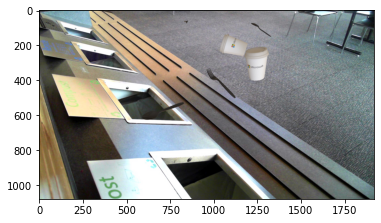

In [93]:
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得
print(f'image shape, (height, width, channels) : ({height}, {width}, {_channels})')

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [94]:
# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = VOCdataset.VOC_DataTransform(input_size, color_mean)


phase = "val"
img_transformed, boxes, labels = transform(img, phase, "", "")
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)
#x = Variable(img.unsqueeze(0))

In [95]:
net.eval()

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [96]:
x = img.unsqueeze(0) 

In [97]:
detections = net(x)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [81]:
# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = VOCdataset.VOC_DataTransform(input_size, color_mean)

img, _boxes, _labels = transform(pil_img, "val", "", "")
img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)
x = Variable(img.unsqueeze(0))

In [83]:
type(x)

torch.Tensor

In [82]:
res = net(x)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

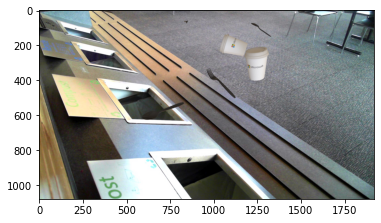

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [72]:
#from dataset import DataTransform
import VOCdataset #import VOC_DataTransform

# 1. 画像読み込み
#image_file_path = "./data/cowboy-757575_640.jpg"
image_file_path = "/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = VOCdataset.VOC_DataTransform(input_size, color_mean)

# 4. 前処理
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # アノテーションはないので、""にする
img_transformed = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)
# img = img_transformed[:, :, (2, 1, 0)].permute(2, 0, 1)

# 5. SSDで予測
net.eval()  # ネットワークを推論モードへ
x = Variable(img_transformed.unsqueeze(0))
#x = img_transformed.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])
#  =（batch_num、クラス、confのtop200、規格化されたBBoxの情報）
#   規格化されたBBoxの情報（確信度、xmin, ymin, xmax, ymax）

In [5]:
all_imgs = []

classes = {}

bbox_threshold = 0.05

# define detections
all_boxes = [[[] for _ in range(len(val_img_list))]
               for _ in range(21)]
empty_array = np.transpose(np.array([[],[],[],[],[]]), (1,0))



In [6]:
#from efficientdet.utils.ssd_predict_show import SSDPredictShow
import VOC_SSD_EVAL
ssd = VOC_SSD_EVAL.SSDPredictShow(eval_categories=voc_classes, net=net, device=device)


cuda:0


#### infer images

In [7]:
for i, imp in enumerate(val_img_list):
    rgb_img, predict_bbox, pre_dict_label_index, scores = ssd.ssd_predict2(imp, data_confidence_level=0.05)
    
    for cls in range(21):
        box = []
        for j,pred in enumerate(predict_bbox):
            if cls == pre_dict_label_index[j]:
                box.append(pred)
        if not box == []:
            all_boxes[cls][i] = box
        else:
            all_boxes[cls][i] = empty_array
    if i%1000==0:
        print("iter:", i)

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [ ]:


# ファイルパス
image_file_path = "/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net, device=device)
ssd.show(image_file_path, data_confidence_level=0.6)

In [31]:
#from VOCdataset import VOC_DataTransform
import VOCdataset, VOC_SSD_EVAL
from torch.autograd import Variable

In [29]:
Tensor = torch.cuda.FloatTensor

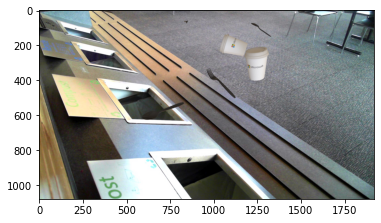

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

In [17]:
# 1. 画像読み込み
image_file_path = "/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = VOCdataset.VOC_DataTransform(input_size, color_mean)

# 4. 前処理
phase = "val"
img_transformed, boxes, labels = transform(img, phase, "", "")  # アノテーションはないので、""にする
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSDで予測
net.eval()  # ネットワークを推論モードへ
x = img.unsqueeze(0).to("cuda")  # ミニバッチ化：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# https://github.com/kentaroy47/BlazeFace_Person.pytorch/blob/master/inference-256.ipynb

In [18]:
import cv2
image_file_path = "/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
img.shape

(1080, 1920, 3)

In [20]:
from efficientdet.utils.ssd_model import DataTransform
import glob
# 画像に対する予測
from efficientdet.utils.ssd_predict_show import SSDPredictShow
# 1. 画像読み込み
image_file_path = "/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg"

ssd = SSDPredictShow(eval_categories=voc_classes, net=net, input_size=256, device="cuda")


TypeError: __init__() got an unexpected keyword argument 'input_size'

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

使用デバイス： cuda:0


In [13]:
from efficientdet.utils.ssd_predict_show import SSDPredictShow

# ファイルパス
image_file_path = "/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net, device=device)
ssd.show(image_file_path, data_confidence_level=0.6)

cuda:0
torch.Size([3, 300, 300])


RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

"""# Class Prediction
Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.
To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.
Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.
```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
"""

print (predict('b_cancer_data2/valid/MALIGNANT/SOB_M_DC-14-2985-200-007.png', loaded_model))


In [5]:

def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class


In [6]:
print (predict("/home/redne/mnt/project_zero/project_zero/ds1/parsed/iter201_InstanceGroup2Desccamera_0camera_Shape0_rgb.jpg", net))

NameError: name 'process_image' is not defined

In [8]:
# Do validation on the test set

def test(model, dataloaders, device):

  model.eval()
  accuracy = 0

  model.to(device)

  for images, labels in dataloaders['valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)

    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    print("Testing Accuracy: {:.3f}".format(
        accuracy/len(dataloaders['valid'])))


In [ ]:
test(net, )

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 2
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('8960_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}
